In [1]:
import h_transport_materials as htm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from analysis_functions import parse_ufloat
from uncertainties import unumpy as unp

/opt/anaconda3/envs/festim2-env/lib/python3.13/site-packages/pybtex/plugin/__init__.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# material_str = "316l_steel"
material_str = "steel"

# filter only 316l_steel and H
diffusivities = htm.diffusivities.filter(material=material_str).filter(isotope="h")
permeabilities = htm.permeabilities.filter(material=material_str).filter(isotope="h")

In [3]:
# --- Edit this path ---
csv_path = f"results/figs/{material_str}_diffusivities.csv"

# --- Read and clean data ---
df = pd.read_csv(csv_path)

# Apply parser to relevant columns
for col in ["Temperature (K)", "Diffusivity", "Permeability"]:
    df[col] = df[col].apply(parse_ufloat)

# Drop rows with missing data
df = df.dropna(subset=["Temperature (K)", "Diffusivity", "Permeability"])

# Sort by the nominal value of Temperature
df = df.sort_values(by="Temperature (K)", key=lambda s: [v.n if hasattr(v, "n") else v for v in s])

# Extract numeric arrays or ufloats
T = df["Temperature (K)"].to_numpy()
D = df["Diffusivity"].to_numpy()
Phi = df["Permeability"].to_numpy()

# Example: to get nominal and std arrays for plotting
T_nom = [t.n if hasattr(t, "n") else t for t in T]
D_nom = [d.n if hasattr(d, "n") else d for d in D]
Phi_nom = [p.n if hasattr(p, "n") else p for p in Phi]
D_std = [d.s if hasattr(d, "s") else 0 for d in D]
Phi_std = [p.s if hasattr(p, "s") else 0 for p in Phi]



In [4]:
# --- Extract nominal values and std devs even if inputs are ufloats ---
T_nom  = unp.nominal_values(T)
D_log  = unp.log(D)               # works for ufloat or float; requires positive values
Phi_log = unp.log(Phi)

yD      = unp.nominal_values(D_log)
yD_std  = unp.std_devs(D_log)
yPhi    = unp.nominal_values(Phi_log)
yPhi_std= unp.std_devs(Phi_log)

# 1/T axis from nominal T
invT = 1.0 / T_nom

# --- Build weights (np.polyfit minimizes sum((w*(y - yhat))^2)) ---
# Use w = 1/sigma; fallback to 1 when std is 0 or missing.
wD   = np.where((yD_std > 0) & np.isfinite(yD_std), 1.0 / yD_std, 1.0)
wPhi = np.where((yPhi_std > 0) & np.isfinite(yPhi_std), 1.0 / yPhi_std, 1.0)

# --- Weighted linear fits: log(D) = a*(1/T) + b, same for Phi ---
# If your NumPy is old and doesn't support 'w=', replace with a manual WLS (shown below).
D_coeffs   = np.polyfit(invT, yD, 1, w=wD)
Phi_coeffs = np.polyfit(invT, yPhi, 1, w=wPhi)

# --- Fit lines across the data range ---
D_invT_fit   = np.linspace(invT.min(), invT.max(), 200)
Phi_invT_fit = D_invT_fit  # same x-range

D_fit   = np.exp(D_coeffs[0] * D_invT_fit   + D_coeffs[1])
Phi_fit = np.exp(Phi_coeffs[0] * Phi_invT_fit + Phi_coeffs[1])

/var/folders/7t/tdtw27sn0rv7xkpyj2z631300000gn/T/ipykernel_40184/1236564672.py:16: RuntimeWarning: divide by zero encountered in divide
  wD   = np.where((yD_std > 0) & np.isfinite(yD_std), 1.0 / yD_std, 1.0)


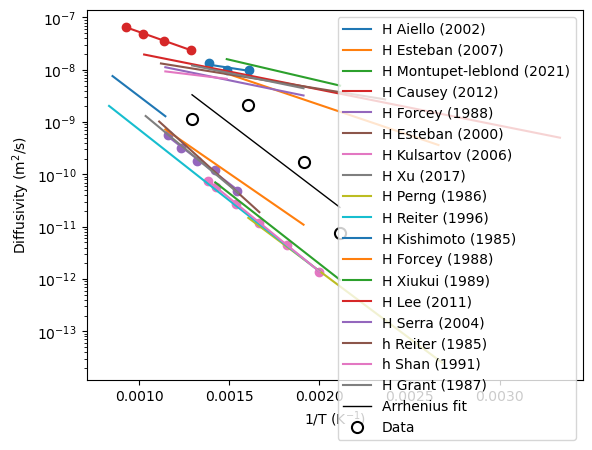

In [5]:
# plot the properties
htm.plotting.plot(diffusivities)

# Overlay Arrhenius fit line
plt.plot(D_invT_fit, D_fit, "k-", linewidth=1, label="Arrhenius fit")

# Overlay measured points as big black circles
plt.plot(invT, D, "ko", markersize=8, markeredgewidth=1.5, markerfacecolor="none", label="Data")

plt.yscale("log")
plt.ylabel("Diffusivity (m$^2$/s)")
plt.legend()
plt.show()

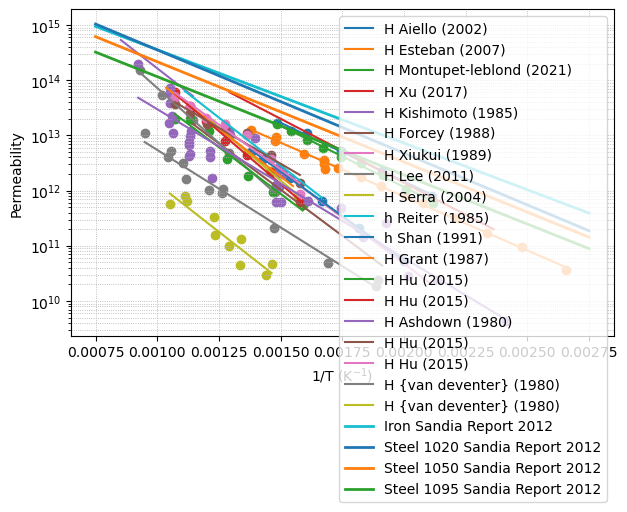

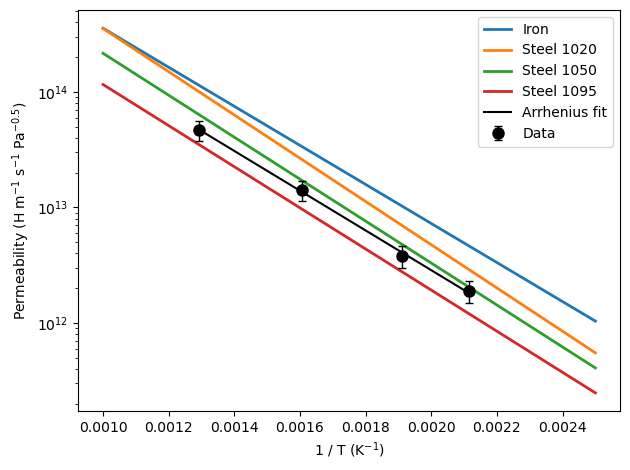

In [6]:
# htm.plotting.plot(permeabilities)


# --- Extract nominal values and std devs ---
invT_nom = [v.n if hasattr(v, "n") else v for v in invT]
Phi_nom  = [v.n if hasattr(v, "n") else v for v in Phi]
Phi_std  = [v.s if hasattr(v, "s") else 0 for v in Phi]

# --- Plot using htm ---
htm.plotting.plot(permeabilities)

if material_str == "steel":
    from low_carbon_steel_plot_digitizer import plot_steel_htm, steel_dataset
    plot_steel_htm(steel_dataset, x_range=[0.001, 0.00250])

# --- Get current axes from the existing plot ---
ax = plt.gca()

# Overlay measured points as solid black circles with error bars
ax.errorbar(
    invT_nom,
    Phi_nom,
    yerr=Phi_std,
    fmt="o",
    markersize=8,
    color="black",
    ecolor="black",
    elinewidth=1,
    capsize=3,
    label="Data"
)

# Overlay the Arrhenius fit line
ax.plot(Phi_invT_fit, Phi_fit, "k-", linewidth=1.5, label="Arrhenius fit")

# Apply the same scaling and labels to keep consistent with htm
ax.set_yscale("log")
ax.set_xlabel("1 / T (K$^{-1}$)")
ax.set_ylabel("Permeability (H m$^{-1}$ s$^{-1}$ Pa$^{-0.5}$)")

# Merge legends if htm already has one
ax.legend()

plt.tight_layout()
plt.show()
